# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [1]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [3]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['dummy5_full.csv','dummy3_full.csv','dummy2_full.csv','dummy1_full.csv']#,
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']

def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        d[idx].get_HRV()
        d[idx].get_PA()
        d[idx].get_sleep(q_sleep=0.4, bed_time = '20:00',wake_time = '12:00', seq_length = 15)
        d[idx].get_windows()
        d[idx].get_SRI(q_sleep=0.4)
        d[idx].get_ARI()
        #d[idx].get_cosinor()
        d[idx].get_SSA()
        d[idx].get_nonlinear()
        #d[idx].Crespo(zeta=15, zeta_r=50, zeta_a=2,t=.50, alpha='7h', beta='1h',
        #              estimate_zeta=False, seq_length_max=100, verbose=False)
        #Depends on running METS,PA,sleep, windows, SRI, SSA and nonlinear first
        d[idx].get_daily_stats()
    return d

d = get_data(filelist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

#Create populatoin-level stats on daily basis
e = defaultdict(dict)
d_pop = pd.DataFrame()
for idx in d.keys():
    #d[idx].get_daily_stats()
    e[idx] = d[idx].daily_stats.copy()
    e[idx]['sub'] = idx
    e[idx]['RMR'] = d[idx].RMR
    e[idx]['VO2max'] = d[idx].VO2max
    e[idx]['age'] = d[idx].age
    e[idx]['BMI'] = d[idx].BMI
    e[idx]['SRI'] = d[idx].SRI
    #e[idx]['ARI'] = d[idx].ARI
    d_pop = pd.concat([d_pop,e[idx]],axis=0)
    

new = d_pop.copy()
#Transform to timedelta columns
new['sleep_onset_t'] = new['sleep_onset']-new.index
new['sleep_offset_t'] = new['sleep_offset']-new.index #timedelta64[ns]
new['ENMO_SSA_phi_t'] = new['ENMO_SSA_phi']-new.index
new['mean_hr_SSA_phi_t'] = new['mean_hr_SSA_phi']-new.index

d_pop_t = new.copy()

#print(d_pop_t.head(10))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#Feature selection and extraction part of the regression pipeline
d_reg = d_pop_t.copy()
#
d_reg2 = d_reg.drop(['sleep_onset', 'sleep_offset','ENMO_SSA_phi','mean_hr_SSA_phi','weekday'],axis=1)

#print(d_reg2.head())
sleep_features = ['TST', 'WASO','AwaNo',
                  'SEff','s_length','dfa_ENMO_sleep','dfa_HR_sleep','dfa_HRV_sleep',
                  'se_ENMO_sleep','se_HR_sleep','se_HRV_sleep','sleep_onset_t','sleep_offset_t']
met_features =['ENMO','MET_Sed','MET_MVPA','MET_VigPA','min_MVPA','min_VigPA','min_LPA']
circ_features = ['ENMO_SSA_per','mean_hr_SSA_per','ENMO_phisleep_delay',
                 'mean_hr_phisleep_delay','ENMO_SSA_phi_t','mean_hr_SSA_phi_t']
deltas = ['TST','ENMO_phisleep_delay','mean_hr_phisleep_delay','sleep_onset_t','sleep_offset_t',
          'ENMO_SSA_phi_t','mean_hr_SSA_phi_t']
shifts = ['ENMO_SSA_per','mean_hr_SSA_per']
fitness = ['RMR','VO2max','BMI','age']
d_reg2[shifts] = d_reg2[shifts].groupby(d_reg2['sub']).shift(-1)
d_reg2[deltas] = d_reg2[deltas].astype('timedelta64[s]')

d_cat = pd.get_dummies(d_reg['weekday'],prefix='weekday',drop_first=True)
#print(d_cat.head())
d_reg2.replace(np.inf, np.nan, inplace=True)
d_reg2 = d_reg2.drop(['sub','ENMO'],axis=1)

scaler = StandardScaler()
d_regs = pd.DataFrame(scaler.fit_transform(d_reg2), columns = d_reg2.columns, index=d_reg2.index).dropna()
d_regsz = pd.concat([d_regs,d_cat],axis=1, join='inner')
#print(d_regs.head())
#print(d_regsz.head())

train_score: 0.9997684618702232
test_score: -3.8031970574966345
0.8018352228333654
                   0         1         2
0           MET_MVPA -0.101937  0.333600
1            min_LPA  0.110042  0.595769
2       dfa_HRV_wake  0.171034  0.783026
3       se_ENMO_wake -0.064965  0.534690
4         se_HR_wake -0.158096  0.679331
5             VO2max -0.242260  0.679711
6  mean_hr_SSA_phi_t -0.181508  0.500593
7        weekday_2.0 -0.392562  0.439081
8        weekday_3.0  0.224870  0.634558
9        weekday_6.0 -0.530969  0.581855
                   0         1         2
8        weekday_3.0  0.224870  0.634558
2       dfa_HRV_wake  0.171034  0.783026
1            min_LPA  0.110042  0.595769
3       se_ENMO_wake -0.064965  0.534690
0           MET_MVPA -0.101937  0.333600
4         se_HR_wake -0.158096  0.679331
6  mean_hr_SSA_phi_t -0.181508  0.500593
5             VO2max -0.242260  0.679711
7        weekday_2.0 -0.392562  0.439081
9        weekday_6.0 -0.530969  0.581855


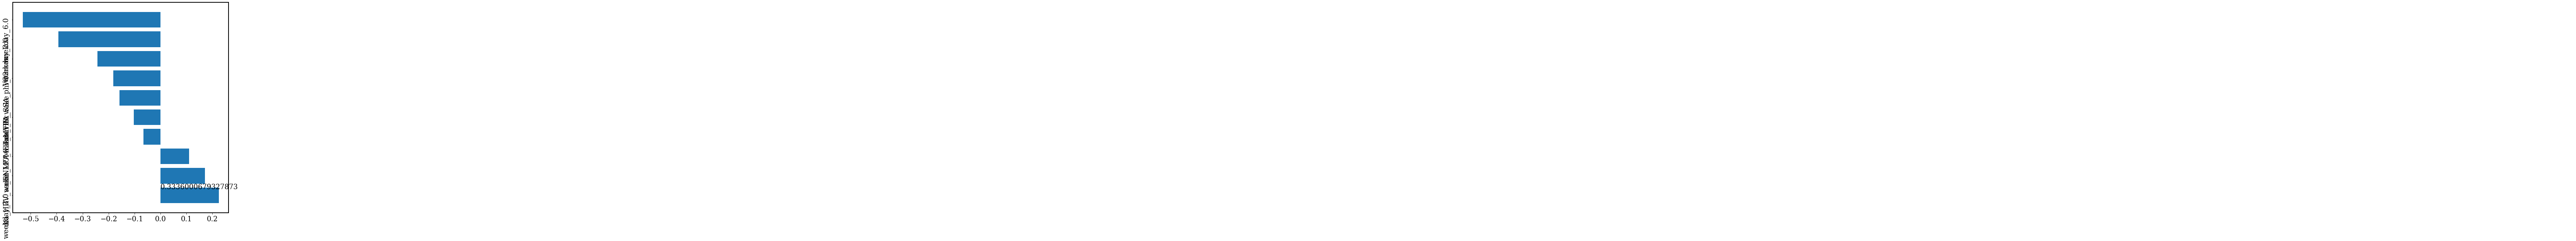

In [30]:
#Recursive Feature Elimination 1
col1 = 'TST'
X_col1 = d_regsz.drop(sleep_features+['MET_VigPA'],axis=1)
y_col1 = d_regsz[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.2, random_state=111)

rfe1 = RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=0)
model_rfe_1 = rfe1.fit(X_train, y_train)

#print(X_train.columns[rfe1.support_])
#print(dict(zip(X_train.columns, rfe1.ranking_)))
#print(rfe1.estimator_.coef_)
print('train_score:',rfe1.score(X_train,y_train))
print('test_score:',rfe1.score(X_test,y_test))



mask = X_train.columns[rfe1.support_]
X_col1 = sm.add_constant(X_col1)
model_col1_sm = sm.OLS(y_train, X_train[mask]).fit() ## sm.OLS(output, input)
predictions = model_col1_sm.predict(X_test[mask])

# Print out the statistics
#print(model_col1_sm.summary())
print(model_col1_sm.rsquared)

# negate the coeff. to sort them in descending order
selected = pd.DataFrame(zip(X_train.columns[rfe1.support_], rfe1.estimator_.coef_, model_col1_sm.pvalues))
print(selected)
sorting = selected.sort_values(1,ascending=False)
print(sorting)

In [18]:
print(sorting[2][5])

0.6797111198461341


In [31]:
#Recursive Feature Elimination 2
col1 = 'SEff'
X_col1 = d_regsz.drop(sleep_features,axis=1)
y_col1 = d_regsz[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.2, random_state=111)

rfe2 = RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=0)
model_rfe_2 = rfe2.fit(X_train, y_train)

#print(X_train.columns[rfe1.support_])
#print(dict(zip(X_train.columns, rfe1.ranking_)))
#print(rfe1.estimator_.coef_)
print('train_score:',rfe2.score(X_train,y_train))
print('test_score:',rfe2.score(X_test,y_test))



mask = X_train.columns[rfe2.support_]
X_col1 = sm.add_constant(X_col1)
model_col2_sm = sm.OLS(y_train, X_train[mask]).fit() ## sm.OLS(output, input)
predictions = model_col2_sm.predict(X_test[mask])

# Print out the statistics
#print(model_col1_sm.summary())
print(model_col2_sm.rsquared)

# negate the coeff. to sort them in descending order
selected2 = pd.DataFrame(zip(X_train.columns[rfe2.support_], rfe2.estimator_.coef_, model_col2_sm.pvalues))
print(selected2)
sorting2 = selected2.sort_values(1,ascending=False)
print(sorting2)

train_score: 0.0
test_score: 0.0
0.8813119151869014
               0             1         2
0        MET_Sed  5.329019e-30  0.173427
1       MET_MVPA -5.077773e-30  0.351727
2      MET_VigPA  3.310328e-28  0.211825
3      min_VigPA -3.271671e-28  0.212972
4        min_LPA  5.708744e-30  0.153109
5  dfa_ENMO_wake  2.889045e-30  0.295699
6    dfa_HR_wake -1.426748e-30  0.764939
7    se_HRV_wake -1.635037e-30  0.627378
8    weekday_1.0  3.381781e-30  0.215252
9    weekday_2.0 -2.319902e-30  0.841095
               0             1         2
2      MET_VigPA  3.310328e-28  0.211825
4        min_LPA  5.708744e-30  0.153109
0        MET_Sed  5.329019e-30  0.173427
8    weekday_1.0  3.381781e-30  0.215252
5  dfa_ENMO_wake  2.889045e-30  0.295699
6    dfa_HR_wake -1.426748e-30  0.764939
7    se_HRV_wake -1.635037e-30  0.627378
9    weekday_2.0 -2.319902e-30  0.841095
1       MET_MVPA -5.077773e-30  0.351727
3      min_VigPA -3.271671e-28  0.212972


In [33]:
#Recursive Feature Elimination 2
col1 = 'SRI'
X_col1 = d_regsz.drop(sleep_features+['SRI'],axis=1)
y_col1 = d_regsz[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.2, random_state=111)

rfe3 = RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=0)
model_rfe_3 = rfe3.fit(X_train, y_train)

#print(X_train.columns[rfe1.support_])
#print(dict(zip(X_train.columns, rfe1.ranking_)))
#print(rfe1.estimator_.coef_)
print('train_score:',rfe3.score(X_train,y_train))
print('test_score:',rfe3.score(X_test,y_test))



mask = X_train.columns[rfe3.support_]
X_col1 = sm.add_constant(X_col1)
model_col3_sm = sm.OLS(y_train, X_train[mask]).fit() ## sm.OLS(output, input)
predictions = model_col3_sm.predict(X_test[mask])

# Print out the statistics
#print(model_col3_sm.summary())
print(model_col3_sm.rsquared)

# negate the coeff. to sort them in descending order
selected3 = pd.DataFrame(zip(X_train.columns[rfe3.support_], rfe3.estimator_.coef_, model_col3_sm.pvalues))
print(selected3)
sorting3 = selected3.sort_values(1,ascending=False)
print(sorting3)

train_score: 1.0
test_score: 1.0
1.0
                 0             1             2
0     dfa_HRV_wake -4.956591e-16  9.438859e-01
1     se_ENMO_wake -2.589440e-16  9.549517e-01
2      se_HRV_wake -1.162673e-15  9.821630e-01
3     ENMO_SSA_per  4.592830e-16  8.927574e-01
4  mean_hr_SSA_per  8.843390e-16  9.763384e-01
5              RMR -2.766039e-01  3.197037e-28
6           VO2max -8.150429e-01  8.215853e-29
7              age  4.671234e-01  7.091113e-29
8   ENMO_SSA_phi_t  2.985133e-16  9.071173e-01
9      weekday_4.0  2.133819e-16  9.841626e-01
                 0             1             2
7              age  4.671234e-01  7.091113e-29
4  mean_hr_SSA_per  8.843390e-16  9.763384e-01
3     ENMO_SSA_per  4.592830e-16  8.927574e-01
8   ENMO_SSA_phi_t  2.985133e-16  9.071173e-01
9      weekday_4.0  2.133819e-16  9.841626e-01
1     se_ENMO_wake -2.589440e-16  9.549517e-01
0     dfa_HRV_wake -4.956591e-16  9.438859e-01
2      se_HRV_wake -1.162673e-15  9.821630e-01
5              RMR -2.7

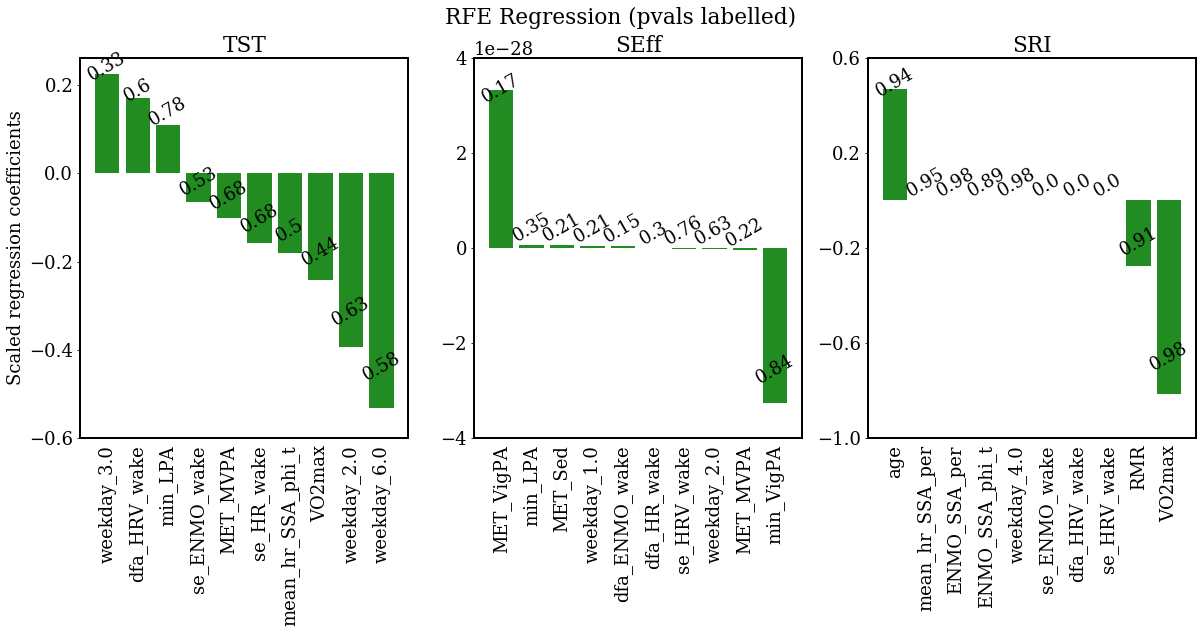

In [91]:
def plot_reg(sorting, sorting2,sorting3):
    fig, ax = plt.subplots(1, 3, figsize= (20, 7))
    def autolabel(rects,sorting, idx):
        for i,rect in enumerate(rects):
            height = rect.get_height()
            ax[idx].text(rect.get_x() + rect.get_width()/2., 0.90*height,round(sorting[2][i],2),
                         ha='center', va='bottom',rotation=30)
    
    rects0 = ax[0].bar(sorting[0], sorting[1],facecolor='forestgreen')
    ax[0].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=90)
    ax[0].set_ylabel('Scaled regression coefficients')
    
    rects1 = ax[1].bar(sorting2[0], sorting2[1],facecolor='forestgreen')
    ax[1].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=90)
    
    rects2 = ax[2].bar(sorting3[0], sorting3[1],facecolor='forestgreen')
    ax[2].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=90)
    
    ax[0].set_yticks(ax[0].get_yticks()[::2])
    ax[1].set_yticks(ax[1].get_yticks()[::2])
    ax[2].set_yticks(ax[2].get_yticks()[::2])
    
    ax[0].title.set_text('TST')
    ax[1].title.set_text('SEff')
    ax[2].title.set_text('SRI')
    
    autolabel(rects0,sorting,0)
    autolabel(rects1,sorting2,1)
    autolabel(rects2,sorting3, 2)
    fig.suptitle('RFE Regression (pvals labelled)')
    return fig

freg = plot_reg(sorting, sorting2,sorting3)
freg.savefig('reg1.png')
freg.show()